In [1]:
# %%
import sys
sys.path.append("..")
from dataset.dataloader import MyOcrDataloader, MyCustomOcrDataloader
import pandas as pd
import math
import random
import torch
import yaml
import wandb
import os
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import gc
from utils.utils import *
from utils.charactertokenizer import CharacterTokenizer
import jiwer
from models.models import TrOCRMyDecoder
from tqdm.auto import tqdm
from torchvision import transforms


/home/ubuntu/datagen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config {'SCENARIO': 1, 'DATASET_PATH': '/data/synthetic_data/labels/output_labels.csv', 'TRAIN_PATH': '/data/handwritten_line_mapping_merged_train_data.csv', 'VAL_PATH': '/data/handwritten_line_mapping_merged_test_data.csv', 'IMG_ROOT': '/data/extracted_handwritten_lines', 'BATCH_SIZE': 64, 'MODEL_ID': 'microsoft/trocr-base-handwritten', 'EPOCHS': 100, 'batch_size': 128, 'enc_dropout': 0.2, 'enc_num_layers': 1, 'enc_num_heads': 1, 'dec_dropout': 0.2, 'dec_num_layers': 4, 'dec_num_heads': 4, 'd_model': 512, 'd_ff': 2048, 'learning_rate': '1E-4', 'optimizer': 'AdamW', 'momentum': 0.0, 'nesterov': True, 'scheduler': 'CosineAnnealing', 'factor': 0.9, 'patience': 6, 'epochs': 100, 'Name': 'blessed'}


In [2]:
tokenizer = CharacterTokenizer.from_pretrained('/home/ubuntu/HandWritten_Amharic_English_OCR/Amharic_Char_Tokenizer2')
# %%
config_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), "config/main.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
DATASET_PATH =config["DATASET_PATH"]
TRAIN_PATH =config["TRAIN_PATH"]
VAL_PATH =config["VAL_PATH"]


MODEL_ID = config["MODEL_ID"]


Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors


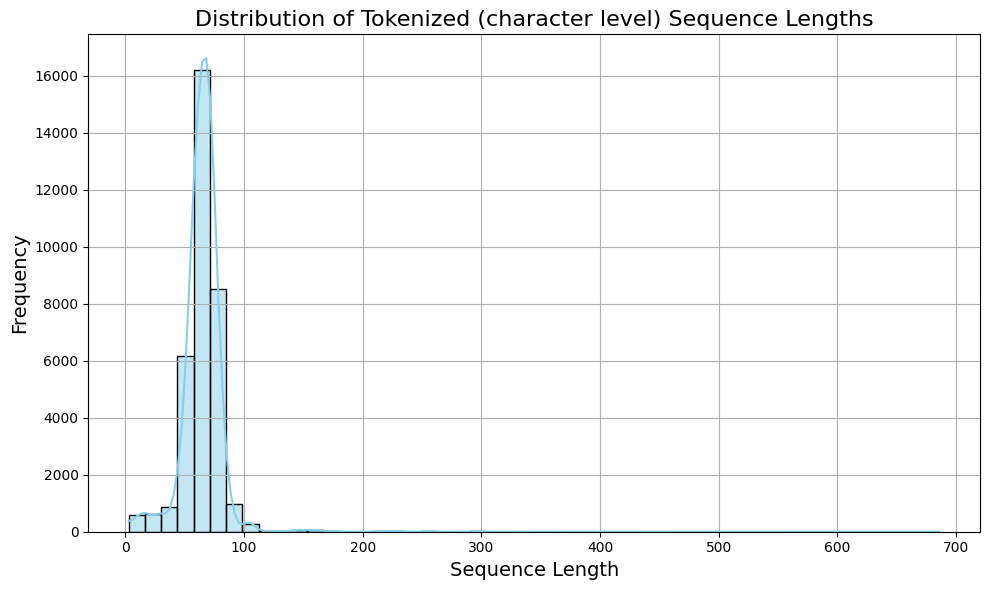

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


seq_length = []
data = pd.read_csv(TRAIN_PATH)

for i in range(len(data)):
    text = data.iloc[i]["text"]
    seq_length.append(len(tokenizer(text).input_ids))
data = pd.read_csv(VAL_PATH)

for i in range(len(data)):
    text = data.iloc[i]["text"]
    seq_length.append(len(tokenizer(text).input_ids))


plt.figure(figsize=(10, 6))
sns.histplot(seq_length, bins=50, kde=True, color="skyblue")
plt.title("Distribution of Tokenized (character level) Sequence Lengths", fontsize=16)
plt.xlabel("Sequence Length", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
data = pd.read_csv(VAL_PATH)
# data = data[data["text"]!= '']


In [27]:
data["text"][100].strip()

'( አጼ ሚኒሊክ  ፣ አጼ ሃይለስላሴ  ፣ ጓድ መንግሰቱ  እና ጠ / ሚ መለስ  እንዴት  የስልጣን  መድላድላቸውን  እንዳደላደሉና'

In [21]:
data[data["text"].str.len() ==1]

,images,text
20,1825_line_11.png,\n
219,2692_line_13.png,\n
272,741_line_13.png,\n
393,1631_line_13.png,\n
501,3045_line_13.png,\n
625,3701_line_13.png,\n
1329,3371_line_12.png,\n
1367,770_line_8.png,\n
1430,2975_line_13.png,\n
1511,2468_line_7.png,\n
